In [1]:
import optuna

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

c:\Users\vlada\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Прежде чем перейти к обучению более сложной модели, проведем предобработку данных (возьмем ее из предыдущей практики)

In [2]:
data = pd.read_csv("Video_Games_Sales.csv", encoding='cp1252')
data['User_Score'] = data['User_Score'].str.replace('tbd', '0').astype(float)
data['User_Score'] = data['User_Score'].fillna('0').astype(float)
data['User_Count'] = data['User_Count'].fillna('0').astype(float)
data['Critic_Score'] = data['Critic_Score'].fillna('0').astype(float)
data['Critic_Count'] = data['Critic_Count'].fillna('0').astype(float)
data = data.dropna(subset="Rating")
data.loc[data.isnull().any(axis=1)]
data = data.dropna(subset="Year_of_Release")
data = data.dropna(subset="Publisher")
df = data.copy()
df.drop('NA_Sales', inplace=True, axis=1)
df.drop('EU_Sales', inplace=True, axis=1)
df.drop('JP_Sales', inplace=True, axis=1)
df.drop('Other_Sales', inplace=True, axis=1)
df.drop('Name', inplace=True, axis=1)
cat_cols = df.select_dtypes(include="object")
le = LabelEncoder()
df['Rating'] = le.fit_transform(cat_cols['Rating'])
columns_to_encode = ['Platform', 'Genre', 'Publisher', 'Developer']
for c in columns_to_encode:
    dummies = pd.get_dummies(df[c], drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop(c, axis=1, inplace=True)
df = df.replace({True: 1, False: 0})
df.head(-5)


,Year_of_Release,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,DC,DS,GBA,...,id Software,"id Software, Nerve Software","id Software, Raven Software",n-Space,neo Software,odenis studio,oeFun,puzzle.tv,syn Sophia,zSlide
0,2006.0,82.53,76.0,51.0,8.0,322.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008.0,35.52,82.0,73.0,8.3,709.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2009.0,32.77,80.0,73.0,8.0,192.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2006.0,29.80,89.0,65.0,8.5,431.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,2006.0,28.92,58.0,41.0,6.6,129.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16685,1997.0,0.01,0.0,0.0,8.1,12.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16692,2011.0,0.01,0.0,0.0,0.0,0.0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16696,2014.0,0.01,80.0,20.0,7.6,412.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16699,2001.0,0.01,67.0,9.0,0.0,0.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 1. Построить более сложную модель с подбором гиперпараметров 

Для поиска оптимальных гиперпараметров воспользуемся фреймворком Optuna 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
X = df.drop(columns = 'Global_Sales')
Y = df['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Рассмотрим 2 варианта проверки качества моделей

1 способ (менее надежный, зато более быстрый) - обучение модели на тренировочных данных и оценка предсказания

2 способ (более надежный, но занимает большее количество времени) - использование cross_val_score 

P.S. при n_trial=5 1 способ показал результат лучше

In [4]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 150) # количество деревьев
    max_depth = trial.suggest_int('max_depth', 3, 15) #  максимальная глубина каждого дерева
    
    # Создание модели Случайный лес с выбранными гиперпараметрами
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    
    # 1 способ (менее надежный, зато более быстрый) - обучение модели на тренировочных данных и оценка предсказания:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    # 2 способ:
    # Оценка модели с кросс-валидацией
    # score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    # mae = -score.mean()
    return mae

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=80)

[I 2024-03-17 20:53:20,209] A new study created in memory with name: no-name-98bb185c-3e5d-4d4e-a85b-82d4b1a48fbd
[I 2024-03-17 20:53:36,328] Trial 0 finished with value: 0.40938413199151374 and parameters: {'n_estimators': 127, 'max_depth': 7}. Best is trial 0 with value: 0.40938413199151374.
[I 2024-03-17 20:54:02,437] Trial 1 finished with value: 0.4143834441134956 and parameters: {'n_estimators': 132, 'max_depth': 7}. Best is trial 0 with value: 0.40938413199151374.
[I 2024-03-17 20:54:35,008] Trial 2 finished with value: 0.4236295316093067 and parameters: {'n_estimators': 137, 'max_depth': 6}. Best is trial 0 with value: 0.40938413199151374.
[I 2024-03-17 20:54:55,007] Trial 3 finished with value: 0.39399879149326605 and parameters: {'n_estimators': 64, 'max_depth': 9}. Best is trial 3 with value: 0.39399879149326605.
[I 2024-03-17 20:55:30,118] Trial 4 finished with value: 0.3729598341977917 and parameters: {'n_estimators': 94, 'max_depth': 12}. Best is trial 4 with value: 0.3729

In [6]:
print("Best value (MAE):", study.best_value)
print("Best parameters:", study.best_params)
print(study.best_trial)

Best value (MAE): 0.3548535504495926
Best parameters: {'n_estimators': 93, 'max_depth': 15}
FrozenTrial(number=49, state=1, values=[0.3548535504495926], datetime_start=datetime.datetime(2024, 3, 17, 21, 25, 51, 795311), datetime_complete=datetime.datetime(2024, 3, 17, 21, 26, 31, 161263), params={'n_estimators': 93, 'max_depth': 15}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=15, log=False, low=3, step=1)}, trial_id=49, value=None)


При количестве обходов, равному 100, MAE в данной задаче (0.354374686039254) примерно в два раза меньше, чем в предыдущей (0.628189211266312). Следовательно, можно сделать вывод, что данная модель примерно в 2 раза лучше

In [7]:
# Получение лучших гиперпараметров из Study
best_params = study.best_params

model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [8]:
new_df = pd.DataFrame({'Actual': y_test, "Predicted": y_pred}) 
print(new_df.head())

       Actual  Predicted
8219     0.17   0.213118
13423    0.05   0.165655
7970     0.19   0.167937
4434     0.44   0.892822
3134     0.64   0.429562


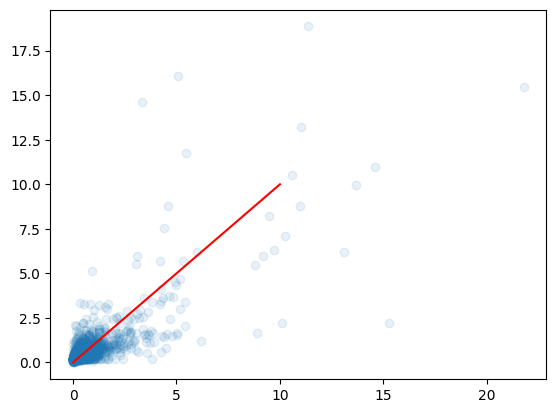

In [9]:
from matplotlib import pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.1)
(plt.plot([0, 10], [0, 10], 'r-'))

Сравнивая итог оценивания с предыдущим предсказанием (с помощью модели регрессии), можно сделать вывод, что теперь данные предсказаны точнее

## 2. Проинтерпретировать полученную модель

In [10]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

По данному графику видно, что после 20 попытки оценка предсказания менялась незначительно, следовательно можно остановиться на этом количестве

In [11]:
from optuna.visualization import plot_slice

plot_slice(study)

По первому графику видно, что в целом максимальное значение max_depth было подобрано хорошо, хотя можно было бы поставить 14 вместо 15, так как это не сильно повлияло бы на модель. По второму графику можно сделать вывод, что для n_esrimators можно было поставить ограничение около 130

In [12]:
import shap

In [13]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

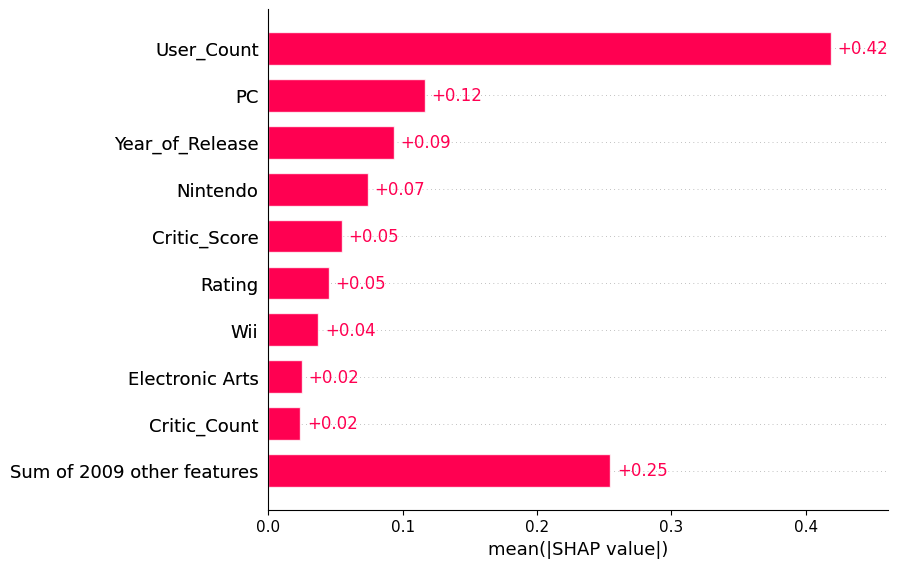

In [14]:
shap.plots.bar(shap_values)

Проанализировав, какие признаки в целом больше всего влияют на прогноз, можно сделать вывод, что количество пользователей оказывает самое большое влияние. Также больше влияние оказывают год выпуска игры и PC

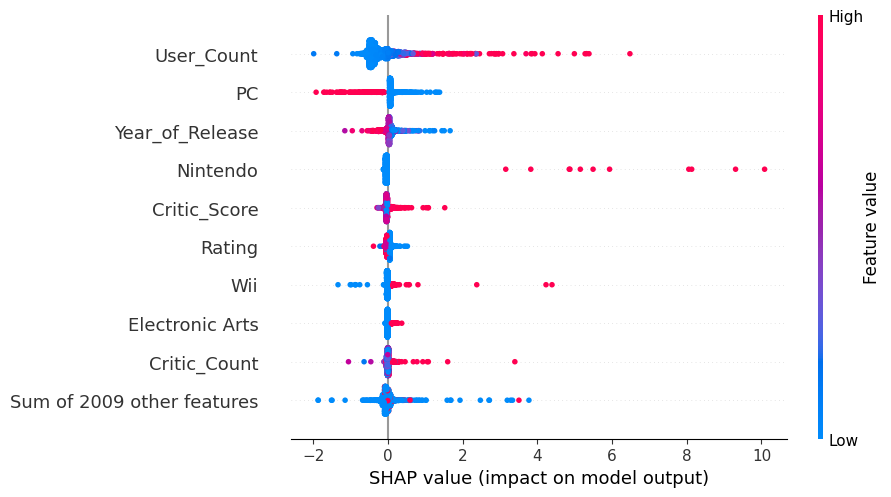

In [15]:
shap.plots.beeswarm(shap_values)

Проанализировав самые влиятельные на предсказание признаки, по данному графику можно сделать вывод, что чем больше пользователей - тем лучше итоговые продажи игры, при этом старые игры являются более продаваемыми, чем новые. В целом это логично, а значит, что модель сделала правильные предсказания 

Далее рассмотрим отдельные предсказания

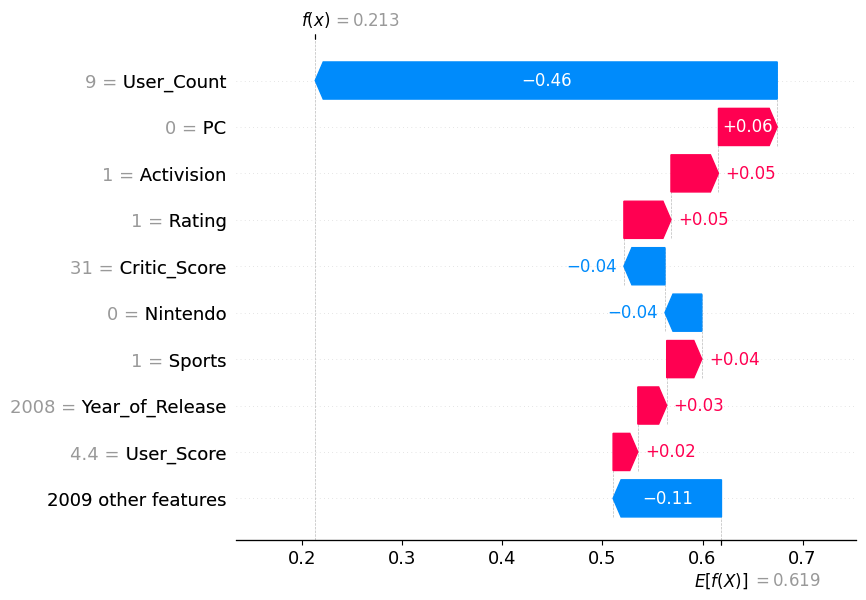

In [16]:
shap.plots.waterfall(shap_values[0])

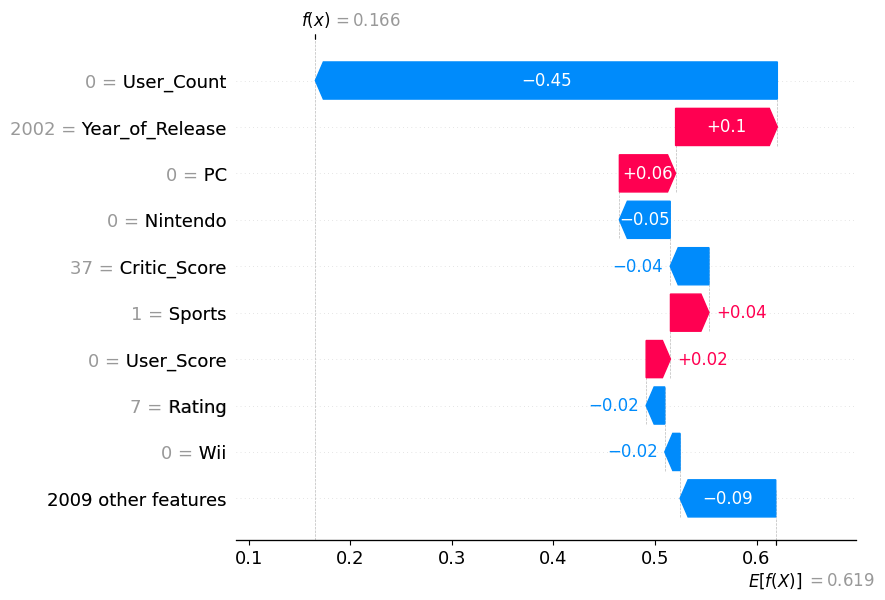

In [17]:
shap.plots.waterfall(shap_values[1])

Сравнивая значения первого и второго предсказания, можно сделать вывод, что количество пользователей больше всего повлияли на прогноз, и остальные значения имели примерно одинаковое влияние

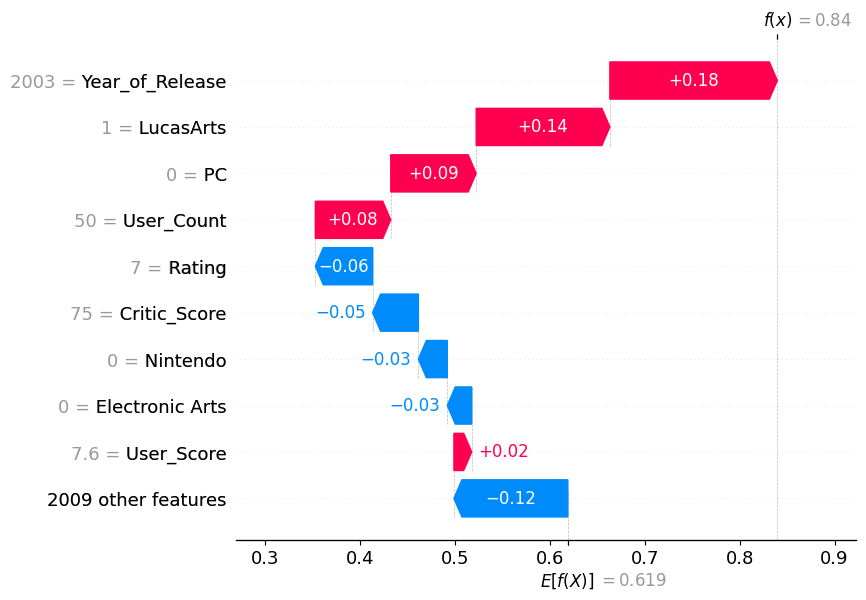

In [18]:
shap.plots.waterfall(shap_values[5])

Для 5 предсказания самое большое влияние оказал год выпуска, и в целом остальные признаки имели не такую же значимость, как в предыдущих случаях. Сделаем вывод, что в разных случаях модель ставит в приоритет разные параметры, что говорит о её качестве